# YOLOv3 图像识别完整教程

本教程涵盖了 YOLOv3 的完整使用流程，从安装到执行目标检测。

## 1. 环境准备与安装

In [1]:
# 检查 GPU 是否可用（可选）
!nvidia-smi

In [1]:
# 安装必要的依赖（假设 OpenCV 已安装，若未安装则需要安装）
!pip install opencv-python numpy matplotlib

## 2. 导入必要的库

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Image as IPImage

# 设置 matplotlib 显示参数
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## 3. 加载 YOLOv3 预训练模型

我们将使用 YOLOv3 的预训练权重（yolov3.weights）和配置文件（yolov3.cfg）。这些文件可以从 YOLO 官方网站下载:
- yolov3.weights: https://pjreddie.com/media/files/yolov3.weights
- yolov3.cfg: https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg
- coco.names: https://github.com/pjreddie/darknet/blob/master/data/coco.names


In [4]:
# 下载 YOLOv3 模型文件（如果尚未下载）

net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

# 加载类别名称
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# 获取输出层名称
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

print(f'模型加载完成: {classes}')

模型加载完成: ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## 4. 准备测试图像

这里我们提供两种方式获取测试图像:
1. 从网络下载
2. 使用本地图像

/Users/lichengtong/anaconda3/envs/yolov11/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lichengtong/anaconda3/envs/yolov11/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lichengtong/anaconda3/envs/yolov11/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lichengtong/anaconda3/envs/yolov11/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


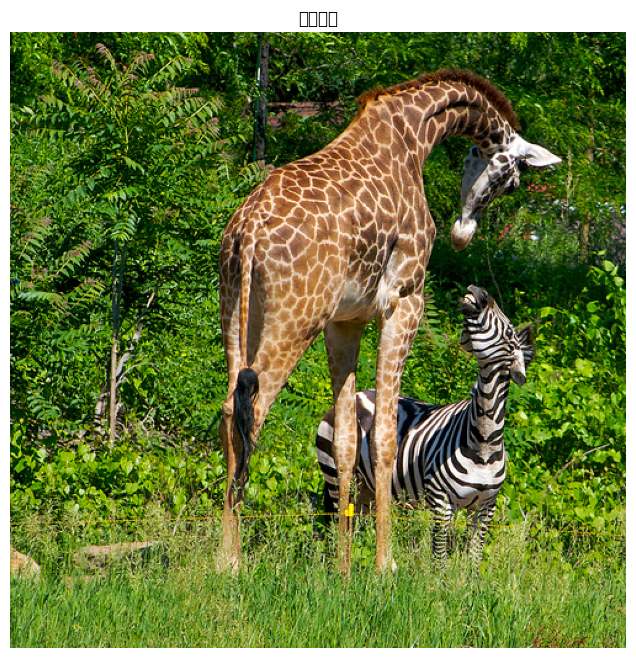

In [7]:


# 显示原始图像
img = cv2.imread('./yolo-images/giraffe.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title('测试图像')
plt.axis('off')
plt.show()

## 5. 定义 YOLOv3 检测函数

/Users/lichengtong/anaconda3/envs/yolov11/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lichengtong/anaconda3/envs/yolov11/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lichengtong/anaconda3/envs/yolov11/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


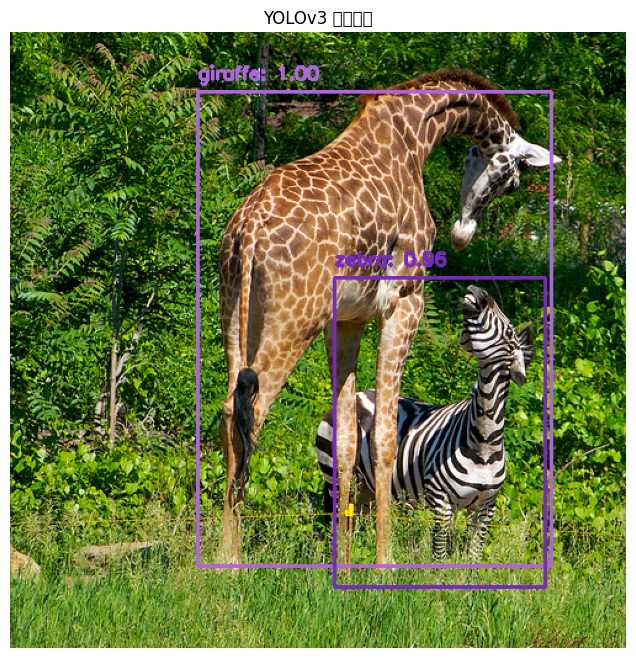

In [9]:
def detect_objects(image, net, output_layers, conf_threshold=0.5, nms_threshold=0.4):
    height, width = image.shape[:2]
    
    # 前处理：调整图像大小并归一化
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    
    # 前向传播
    outputs = net.forward(output_layers)
    
    # 解析检测结果
    boxes, confidences, class_ids = [], [], []
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    # 非极大值抑制 (NMS)
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    
    # 绘制检测结果
    result_image = image.copy()
    detections = []
    for i in indices:
        box = boxes[i]
        x, y, w, h = box
        label = f'{classes[class_ids[i]]}: {confidences[i]:.2f}'
        color = [int(c) for c in np.random.randint(0, 255, size=3)]
        cv2.rectangle(result_image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(result_image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        detections.append({
            'class': classes[class_ids[i]],
            'confidence': confidences[i],
            'box': [x, y, x + w, y + h]
        })
    
    return result_image, detections

# 测试检测函数
img = cv2.imread('./yolo-images/giraffe.jpg')
result_image, detections = detect_objects(img, net, output_layers, conf_threshold=0.5, nms_threshold=0.4)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('YOLOv3 检测结果')
plt.axis('off')
plt.show()

## 6. 处理视频文件 (可选)

In [8]:
# 处理视频并保存结果
cap = cv2.VideoCapture('bus.mp4')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_video.mp4', fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    result_frame, _ = detect_objects(frame, net, output_layers)
    out.write(result_frame)

cap.release()
out.release()
print('视频处理完成，结果保存在 output_video.mp4')

## 7. 获取并处理检测结果数据 (高级用法)

边界框数量: 2
类别: giraffe, 置信度: 1.00, 边界框: [152, 48, 439, 433]
类别: zebra, 置信度: 0.96, 边界框: [263, 199, 434, 450]


/Users/lichengtong/anaconda3/envs/yolov11/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lichengtong/anaconda3/envs/yolov11/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lichengtong/anaconda3/envs/yolov11/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20041 (\N{CJK UNIFIED IDEOGRAPH-4E49}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lichengtong/anaconda3/envs/yolov11/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lichengtong/anaconda3/envs/yolov11/lib/python3.9/

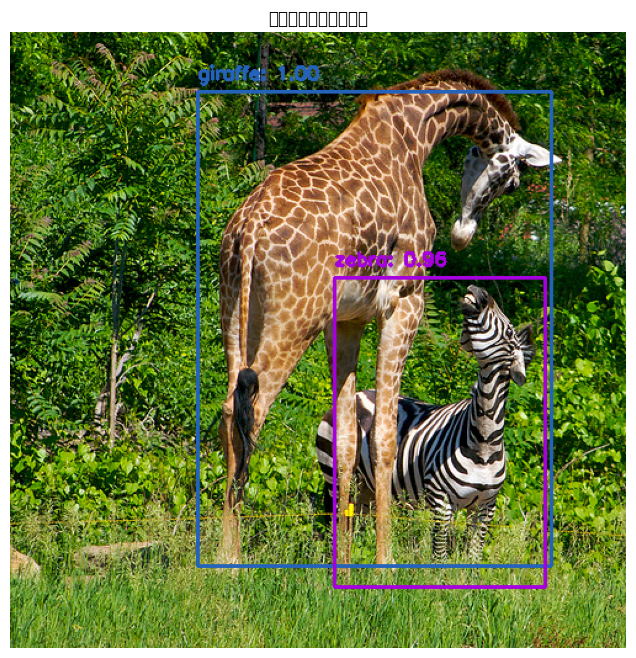

In [10]:
# 执行检测并获取详细结果
img = cv2.imread('./yolo-images/giraffe.jpg')
result_image, detections = detect_objects(img, net, output_layers)

# 打印检测结果
print('边界框数量:', len(detections))
for detection in detections:
    print(f"类别: {detection['class']}, 置信度: {detection['confidence']:.2f}, 边界框: {detection['box']}")

# 显示结果
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title('自定义检测结果可视化')
plt.axis('off')
plt.show()

## 8. 保存检测结果

In [11]:
# 创建保存结果的目录
os.makedirs('detection_results', exist_ok=True)

# 定义图像路径列表（这里仅示例一个）
image_paths = ['./yolo-images/giraffe.jpg', './yolo-images/eagle.jpg']

# 对所有图片进行检测并保存结果
for img_path in image_paths:
    # 执行检测
    img = cv2.imread(img_path)
    result_image, detections = detect_objects(img, net, output_layers)
    
    # 保存包含检测结果的图像
    output_path = f'detection_results/result_{os.path.basename(img_path)}'
    cv2.imwrite(output_path, result_image)
    print(f'检测结果保存到: {output_path}')
    
    # 保存检测结果的文本信息到 TXT 文件
    txt_path = f'detection_results/result_{os.path.basename(img_path).split(".")[0]}.txt'
    with open(txt_path, 'w') as f:
        f.write(f'检测结果 - {img_path}\n')
        f.write('-' * 50 + '\n')
        for detection in detections:
            f.write(f"类别: {detection['class']}, 置信度: {detection['confidence']:.4f}\n")
            f.write(f"边界框: {detection['box']}\n")
            f.write('-' * 30 + '\n')
    print(f'检测信息保存到: {txt_path}')

检测结果保存到: detection_results/result_giraffe.jpg
检测信息保存到: detection_results/result_giraffe.txt
检测结果保存到: detection_results/result_eagle.jpg
检测信息保存到: detection_results/result_eagle.txt


## 9. 总结

在本教程中，我们完成了以下任务:
1. 安装了必要的依赖
2. 加载了预训练的 YOLOv3 模型
3. 对图像进行了目标检测
4. 可视化了检测结果
5. 处理了视频文件
6. 自定义处理检测结果数据
7. 保存了检测结果和信息

YOLOv3 是经典的目标检测模型，更多信息可参考官方文档: https://pjreddie.com/darknet/yolo/
